In [1]:
from weather_co2_dataset import WeatherCO2DataModule
import torch
import numpy as np
import pandas as pd


codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]

features_data = []
targets_data = []
for code in codes:
    features = np.load(f"electricitymaps_datasets/{code}_np_dataset.npy", allow_pickle=True)
    features_data.append(features)

    emission_df = pd.concat(
        (
            pd.read_csv(f"electricitymaps_datasets/{code}_2021_hourly.csv"),
            pd.read_csv(f"electricitymaps_datasets/{code}_2022_hourly.csv"),
        )
    ).reset_index(drop=True)
    target = emission_df["Carbon Intensity gCO₂eq/kWh (LCA)"].to_numpy()
    targets_data.append(target)


dm = WeatherCO2DataModule(
    features_data, targets_data, 24, 24, 10, 16
)
dm.setup('fit')

2023-07-11 11:36:18.364767: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 11:36:18.419501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:36:19.238470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
len(dm.val_dataset.datasets[0])

5209

In [6]:
import sys
sys.path.append("scheduler_vm_task/master_machine/")


from scheduler_vm_task.master_machine.co2_model import CO2Model
from lightning.pytorch import Trainer
import os 

model = CO2Model(
    tcn_hparams={
        "num_inputs": 24*38,
        # "num_channels": [64, 128, 128, 128, 256],
        "num_channels": [512, 256, 256, 256, 256],
        "kernel_size": 3,
        "dropout": 0.0,
    },
    attention_layers_num = 8,
    predict_window=24,
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

# For WandB local checkpoints
def find_checkpoint(name):
    folder = f'SmartScheduler/{name}/checkpoints'
    for file in os.listdir(folder):
        if file.endswith('.ckpt'):
            return f'{folder}/{file}'

# model = model.load_from_checkpoint(find_checkpoint('ya6oc29o'))
model = model.load_from_checkpoint(find_checkpoint('fcqpzi1c'))

# co2_model.ckpt can be downloaded here (rename it):
# https://api.wandb.ai/artifactsV2/gcp-us/mtyutyulnikov/QXJ0aWZhY3Q6NDc3MDUyNjUw/6c14bec74f1261169f7b083c1d27c6a9/model.ckpt?_gl=1*brpj4j*_ga*Mjk0MzUwODY2LjE2ODU2NzQ2NDY.*_ga_JH1SJHJQXJ*MTY4NjAzOTk3MC4xNi4xLjE2ODYwMzk5OTUuMzUuMC4w

# model = model.load_from_checkpoint('co2_model.ckpt')

trainer = Trainer(
    accelerator="gpu",
    devices=[0],
)

val_preds = trainer.predict(model, dm.val_dataloader())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [7]:
find_checkpoint('ya6oc29o')

'SmartScheduler/ya6oc29o/checkpoints/epoch=5-step=14892.ckpt'

In [8]:
len(val_preds), val_preds[0].shape, val_preds[-1].shape

(4233, torch.Size([16, 24]), torch.Size([5, 24]))

In [9]:
val_preds = torch.cat(val_preds, dim=0)
targets =  torch.stack([dm.val_dataset[idx][1] for idx in range(len(dm.val_dataset))])
val_preds.shape, targets.shape

(torch.Size([67717, 24]), torch.Size([67717, 24]))

In [10]:
features = torch.stack([dm.val_dataset[i][0] for i in range(len(dm.val_dataset))])
features.shape

torch.Size([67717, 24, 24, 38])

In [11]:
torch.save(features, 'features.pt')
torch.save(val_preds, 'preds.pt')
torch.save(targets, 'targets.pt')


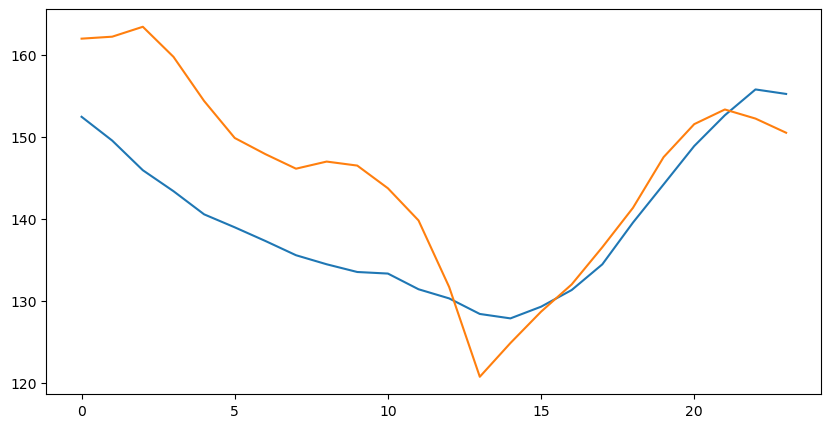

In [12]:
import matplotlib.pyplot as plt

sample_id = 200
plt.figure(figsize=(10, 5))
plt.plot(val_preds[sample_id], label='pred')
plt.plot(targets[sample_id] , label='val')

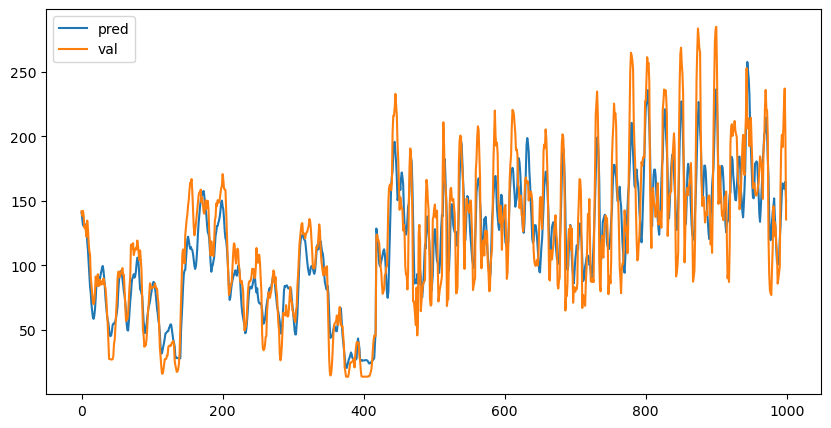

In [13]:
import matplotlib.pyplot as plt

time_step = 0
s1, s2 = 10000, 11000
plt.figure(figsize=(10, 5))
plt.plot(val_preds[s1 :s2, time_step], label='pred')
plt.plot(targets[s1 :s2, time_step] , label='val')
plt.legend()

In [9]:
from sklearn.metrics import mean_absolute_error
for i in range(24):
    print(f'Forecast time_step {i}: \t MAE = {mean_absolute_error(val_preds[:, i], targets[:, i])}')

Forecast time_step 0: 	 MAE = 12.301214218139648
Forecast time_step 1: 	 MAE = 14.97998332977295
Forecast time_step 2: 	 MAE = 17.382526397705078
Forecast time_step 3: 	 MAE = 19.454370498657227
Forecast time_step 4: 	 MAE = 21.30758285522461
Forecast time_step 5: 	 MAE = 22.743526458740234
Forecast time_step 6: 	 MAE = 23.913816452026367
Forecast time_step 7: 	 MAE = 24.861614227294922
Forecast time_step 8: 	 MAE = 25.564157485961914
Forecast time_step 9: 	 MAE = 26.244068145751953
Forecast time_step 10: 	 MAE = 26.883647918701172
Forecast time_step 11: 	 MAE = 27.458576202392578
Forecast time_step 12: 	 MAE = 28.006433486938477
Forecast time_step 13: 	 MAE = 28.61688995361328
Forecast time_step 14: 	 MAE = 29.104202270507812
Forecast time_step 15: 	 MAE = 29.53734588623047
Forecast time_step 16: 	 MAE = 29.970260620117188
Forecast time_step 17: 	 MAE = 30.32082748413086
Forecast time_step 18: 	 MAE = 30.56966781616211
Forecast time_step 19: 	 MAE = 30.65277862548828
Forecast time_ste

In [10]:
print(f'Total MAE = {mean_absolute_error(val_preds, targets)}')

Total MAE = 25.959115982055664


In [14]:
# Dataset idx from 0 to 12

from sklearn.metrics import mean_absolute_percentage_error
def print_res(predict_period = 24, plot = True, dataset_idx = 0):
    preds = []
    real = []
    codes = ["BR-CS", "CA-ON", "CH", "DE", "PL", "BE", "IT-NO", "CA-QC", "ES", "GB", "FI", "FR", "NL"]


    start_idx = dataset_idx * len(dm.val_dataset.datasets[0])
    end_idx = start_idx + len(dm.val_dataset.datasets[0])
    for i in range(start_idx, end_idx, predict_period):
        preds.extend(val_preds[i, :predict_period])
        real.extend(targets[i, :predict_period])
        # plt.axvline(i, color='r', ds='steps-pre')
    
    if plot:
        plt.figure(figsize=(20, 5))
        plt.plot(preds, label = f'forecast_{predict_period}h_step')
        plt.plot(real, label='real_val')
        plt.legend()
    # print(preds[0])

    print(codes[dataset_idx], mean_absolute_percentage_error(preds, real).round(4)*100)

In [24]:
for i in range(13):
    print_res(predict_period=24, plot=False, dataset_idx=i)

BR-CS 7.660000026226044
CA-ON 29.750001430511475
CH 19.200000166893005


DE 9.399999678134918
PL 5.649999901652336
BE 19.040000438690186
IT-NO 7.429999858140945
CA-QC 3.7399999797344208
ES 13.490000367164612
GB 15.639999508857727
FI 13.330000638961792
FR 12.120000272989273
NL 12.389999628067017


In [25]:
for i in range(13):
    print_res(predict_period=12, plot=False, dataset_idx=i)

BR-CS 6.300000101327896
CA-ON 30.720001459121704
CH 17.669999599456787
DE 8.129999786615372
PL 4.989999905228615
BE 16.339999437332153
IT-NO 6.17000013589859
CA-QC 3.8199998438358307
ES 10.649999976158142
GB 11.680000275373459
FI 11.949999630451202
FR 10.769999772310257
NL 9.860000014305115


In [15]:
for i in range(13):
    print_res(predict_period=6, plot=False, dataset_idx=i)

BR-CS 4.859999939799309
CA-ON 23.090000450611115
CH 17.820000648498535
DE 6.360000371932983
PL 4.179999977350235
BE 15.250000357627869
IT-NO 5.539999902248383
CA-QC 5.380000174045563
ES 8.089999854564667
GB 9.030000120401382
FI 9.099999815225601
FR 9.200000017881393
NL 8.309999853372574


In [27]:
for i in range(13):
    print_res(predict_period=1, plot=False, dataset_idx=i)

BR-CS 4.560000076889992
CA-ON 17.829999327659607
CH 12.080000340938568
DE 3.9299998432397842
PL 2.630000002682209
BE 8.389999717473984
IT-NO 4.129999876022339
CA-QC 4.010000079870224
ES 6.019999831914902
GB 6.190000101923943
FI 9.470000118017197
FR 8.76000002026558
NL 5.999999865889549


BE 0.13


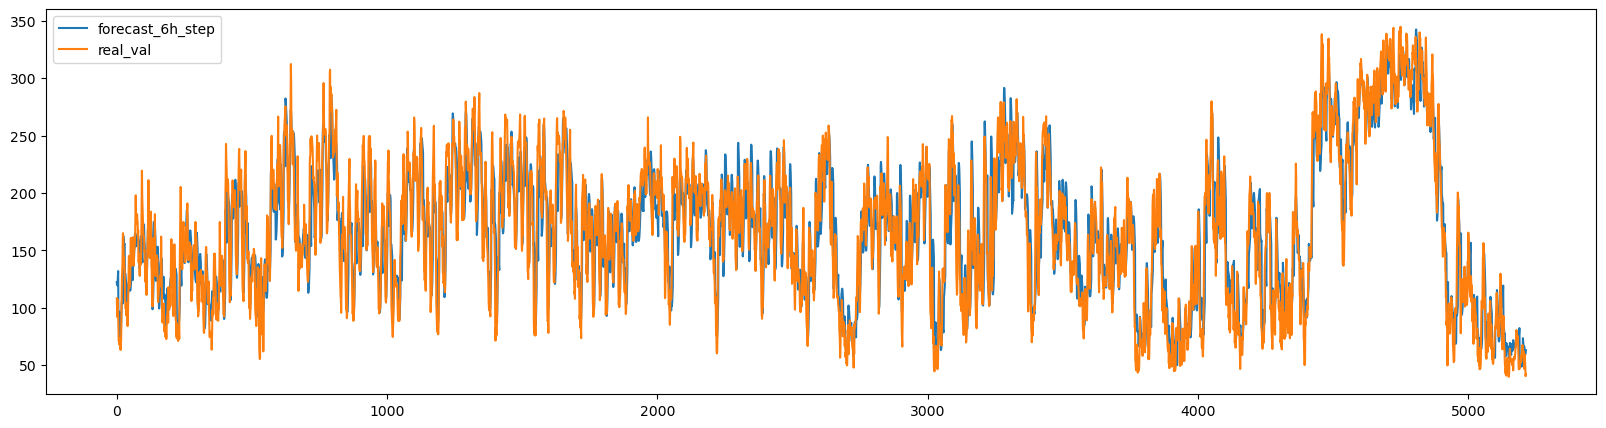

In [22]:
print_res(predict_period=6, plot=True, dataset_idx=5)